Método:
- On considère que chaque sample est un couple de session patchy/uniform
- On sépare patchy de uniform (avant le dict encoding sinon il va fissurer)
- On preprocess (Dict encoding, rescaling/norm peut-être)
- On kfold, pour chaque split:
    - Pour chaque sample du train ou du test, on le sépare en 2, avec Y = 0 pour patchy, 1 Pour uniform
    - On fait le train comme ça, puis le test. Pour chacun, après avoir splitté, il faut penser à shuffle
    - on calcule soit la MSE, soit l'accuracy/F1
    - Idée pour le test: on prend chaque paire, on compare la prédiction, et on regarde si c'est bien classifié ou pas

Classes clefs:
- Kfold
- DictVectorizer
- 


In [19]:
import json
import os
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from neuroforest.dataset import DATA_FOLDER
# from umap import UMAP

In [12]:
FEATURES_PATH = DATA_FOLDER / "trajectory_features.json"

if Path(os.getcwd()).name == "notebooks":
    os.chdir("..")

with FEATURES_PATH.open() as feat_file:
    raw_features: dict[str, dict[str, float]] = json.load(feat_file)

In [13]:
separated_features: dict[str, dict[str, int]] = OrderedDict()
features_list: list[dict[str, float]] = list()
session_types = ["uniform","patchy"]
idx = 0
for subject, feats in raw_features.items():
    sep_feats = {sess_t: dict() for sess_t in session_types}
    for feat_name, feat_val in feats.items():
        if feat_name != "asrs" :
            feat_sess, feat_real_name = feat_name.split("/")
            if feat_sess in sep_feats:
                sep_feats[feat_sess][feat_real_name] = feat_val

    separated_features[subject] = {}
    for sess_type, feats in sep_feats.items():
        separated_features[subject][sess_type] = idx
        features_list.append(feats)
        idx += 1


In [14]:
dict_vectorizer = DictVectorizer(sparse=False)
feats_array = dict_vectorizer.fit_transform(features_list)

In [15]:
kfold = KFold(n_splits=5)

mapping = {"uniform": 0, "patchy": 1}

for train_set, test_set in kfold.split(separated_features):
    train_set, test_set = set(train_set), set(test_set)
    # List of (feat_x, class_y) tuples
    train_samples: list[tuple[np.ndarray, int]] = []
    test_samples: dict[str, list[np.ndarray]] = {sess_type: [] for sess_type in mapping}
    for idx, (subject, sessions) in enumerate(separated_features.items()):
        if idx in train_set:
            for sess_type, sess_id in sessions.items():
                train_samples.append((
                    feats_array[sess_id], mapping[sess_type]
                ))
        if idx in test_set:
            for sess_type, sess_id in sessions.items():
                test_samples[sess_type].append(feats_array[sess_id])

    train_x, train_y = map(np.array, zip(*train_samples))
    scaler = RobustScaler()
    train_x = scaler.fit_transform(train_x)
    train_x, train_y = shuffle(train_x, train_y, random_state=4577)

    for sess_type, test_feats in list(test_samples.items()):
        test_samples[sess_type] = scaler.transform(np.array(test_feats))

    regressor = LinearRegression()
    regressor.fit(train_x, train_y)
    test_pred = {sess_type: regressor.predict(test_feats)
                 for sess_type, test_feats in test_samples.items()}
    print((test_pred["uniform"] < test_pred["patchy"]).mean())

0.875
0.625
0.75
0.7142857142857143
0.42857142857142855


In [16]:
dict_vectorizer.inverse_transform([regressor.coef_])

[{'capture_ratio': 0.1196706102225523,
  'gathered_mushrooms_convex_hull': 0.06473127244315618,
  'gathered_mushrooms_distance': -0.6413763494183667,
  'gathered_mushrooms_trajectory': -0.5584799375554877,
  'performance': 0.3452127247317439,
  'player_convex_hull': -0.10910099924221373,
  'player_distance': 0.6711493037898723,
  'player_trajectory': 0.2441134652407736}]

In [20]:
scaled_feats_array = RobustScaler().fit_transform(feats_array)
tsne = TSNE(n_components=2, random_state=42)
reduced_feats_array = tsne.fit_transform(scaled_feats_array)
reduced_feats_array.shape

(76, 2)

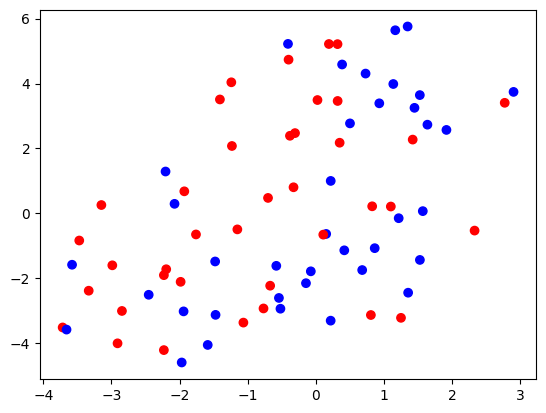

In [21]:
plt.scatter(
    reduced_feats_array[:, 0],
    reduced_feats_array[:, 1],
    c=["red" if i % 2 else "blue" for i in range(len(reduced_feats_array))])